# Machine Learning Exercise

Now it's time to practice what you have seen in the previous notebooks. Your task for today is to download the data from the database and train a model in order to predict if a patient has a heart disease or not. 

![](https://www.nicepng.com/png/detail/397-3975460_disease-high-quality-png-heart-disease-cartoon-png.png)

## Task:

1. Import the data from the database. The schema is called `heart`. You can use DBeaver to get an overview over the different tables and think about a good way to join them. 
2. Split the data into train and test
3. Conduct a brief EDA on the train data to become familiar with the data. 
4. Preprocess the data as far as you need it (feature Engineering)and ...
5. ...train a logistic regression model.

## What you should use/keep in mind:
 
* **Scale your data:** Which scaler works best in your case?
* **Tune your model:** Tune the hyperparameter of your model. You can start with a larger parameter grid and a `RandomizedSearchCV` and continue with a narrower parameter grid for your `GridSearchCV`.
* **Choose the right evaluation metric!**


## Data Overview

| column | additional information |
|--------|------------------------|
| age | age of patient |
| sex | gender of patient |
| chest_pain_type  | 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic | 
| resting_blood_pressure |  | 
| fasting_blood_sugar | > 120 mg/dl, 1 = true, 0 = false | 
| thal | 0 = normal, 1 = fixed defect, 2 = reversable defect
| serum_cholestoral | in mg/dl | 
| resting_electrocardiographic_results | 0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria | 
| maximum_heartrate_achieved | | 
| exercise_induced_angina | 1 = yes, 0 = no | 
| oldpeak | ST depression induced by exercise relative to rest | 
| slope_of_the_peak_exercise_st_segment | 1= upsloping, 2 = flat, 3 = downsloping | 
| number_of_major_vessels_colored_by_flourosopy | |
| real_data | tag to distinguish between real and made up data | 
| heart_attack | 0 = little risk of heart attack, 1 = high risk of heart attack | 

## Import

In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

RSEED = 42

## Getting the Data

The data for this exercise is stored in our postgres database in the schema `heart`. The different features are split thematically into five different tables. Your first task will be to have a look at the tables (e.g. in DBeaver) and figure out a way to join the information you need. As soon as you're happy with your query, you can use the following code cells to import the data into this notebook. 

In previous notebooks you've seen two different approaches to import data from a database into a notebook. The following code will use `sqlalchemy`in combination with pandas `pd.read_sql()` function. For the code to work, you need to copy the `.env` file from the previous repositories into this repository and change the query_string to your own query.

In [9]:
# Read database string from .env file (no need to change anything)
load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)

In [10]:
# Define query to download data (add your query here)
query_string = '''select p.id, p.age, p.sex , bm.fasting_blood_sugar, bm.serum_cholestoral, bm.thal,
cp.chest_pain_type , hah.heart_attack, pva.exercise_induced_angina, pva.maximum_heartrate_achieved,
pva.number_of_major_vessels_colored_by_flourosopy, pva.oldpeak, pva.real_data, pva.resting_blood_pressure,
pva.resting_electrocardiographic_results, pva.slope_of_the_peak_exercise_st_segment  
from heart.patient p
left join heart.blood_metrics bm 
	on p.id = bm.patient_id 
left join heart.chest_pain cp 
	on p.id = cp.patient_id 
left join heart.heart_attack_history hah 
	on p.id = hah.patient_id 
left join heart.pressure_vessels_angina pva 
	on p.id = pva.patient_id;'''

# Import with pandas
df_sqlalchemy = pd.read_sql(query_string, db)
df_sqlalchemy.head()

,id,age,sex,fasting_blood_sugar,serum_cholestoral,thal,chest_pain_type,heart_attack,exercise_induced_angina,maximum_heartrate_achieved,number_of_major_vessels_colored_by_flourosopy,oldpeak,real_data,resting_blood_pressure,resting_electrocardiographic_results,slope_of_the_peak_exercise_st_segment
0,0,63.0,1.0,1.0,233.0,1.0,3.0,1,0.0,150.0,0.0,2.3,real data,145.0,0.0,0.0
1,1,NaN,1.0,0.0,250.0,2.0,2.0,1,0.0,187.0,0.0,3.5,real data,130.0,1.0,0.0
2,2,41.0,0.0,0.0,204.0,2.0,1.0,1,0.0,172.0,0.0,1.4,real data,130.0,0.0,2.0
3,3,56.0,1.0,0.0,236.0,2.0,1.0,1,0.0,178.0,0.0,0.8,real data,120.0,1.0,2.0
4,4,57.0,0.0,0.0,354.0,2.0,0.0,1,1.0,163.0,0.0,0.6,None,120.0,1.0,2.0


In [11]:
# Save dataframe as .csv file
df_sqlalchemy.to_csv("heart_data.csv", index=False)

### Short EDA

In [12]:
df = df_sqlalchemy.copy()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 16 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   id                                             403 non-null    int64  
 1   age                                            393 non-null    float64
 2   sex                                            384 non-null    float64
 3   fasting_blood_sugar                            303 non-null    float64
 4   serum_cholestoral                              303 non-null    float64
 5   thal                                           303 non-null    float64
 6   chest_pain_type                                303 non-null    float64
 7   heart_attack                                   403 non-null    int64  
 8   exercise_induced_angina                        353 non-null    float64
 9   maximum_heartrate_achieved                     342 non

In [14]:
df.isnull().sum()

id                                                 0
age                                               10
sex                                               19
fasting_blood_sugar                              100
serum_cholestoral                                100
thal                                             100
chest_pain_type                                  100
heart_attack                                       0
exercise_induced_angina                           50
maximum_heartrate_achieved                        61
number_of_major_vessels_colored_by_flourosopy     50
oldpeak                                           50
real_data                                        110
resting_blood_pressure                            50
resting_electrocardiographic_results              50
slope_of_the_peak_exercise_st_segment             50
dtype: int64

In [15]:
df.describe()

,id,age,sex,fasting_blood_sugar,serum_cholestoral,thal,chest_pain_type,heart_attack,exercise_induced_angina,maximum_heartrate_achieved,number_of_major_vessels_colored_by_flourosopy,oldpeak,resting_blood_pressure,resting_electrocardiographic_results,slope_of_the_peak_exercise_st_segment
count,403.000000,393.000000,384.000000,303.000000,303.000000,303.000000,303.000000,403.000000,353.000000,342.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,201.000000,55.139949,0.658854,0.148515,246.264026,2.313531,0.966997,0.523573,0.351275,127.915205,1.407932,1.388102,119.441926,8.498584,1.558074
std,116.480327,13.989364,0.474713,0.356198,51.830751,0.612277,1.032052,0.500065,0.478046,56.962882,1.931540,1.389316,35.948474,22.135575,0.717198
min,0.000000,20.000000,0.000000,0.000000,126.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,100.500000,46.000000,0.000000,0.000000,211.000000,2.000000,0.000000,0.000000,0.000000,120.000000,0.000000,0.000000,110.000000,0.000000,1.000000
50%,201.000000,56.000000,1.000000,0.000000,240.000000,2.000000,1.000000,1.000000,0.000000,147.000000,1.000000,1.000000,128.000000,1.000000,2.000000
75%,301.500000,62.000000,1.000000,0.000000,274.500000,3.000000,2.000000,1.000000,1.000000,163.000000,2.000000,2.500000,140.000000,1.000000,2.000000
max,402.000000,99.000000,1.000000,1.000000,564.000000,3.000000,3.000000,1.000000,1.000000,202.000000,6.000000,6.200000,200.000000,99.000000,3.000000


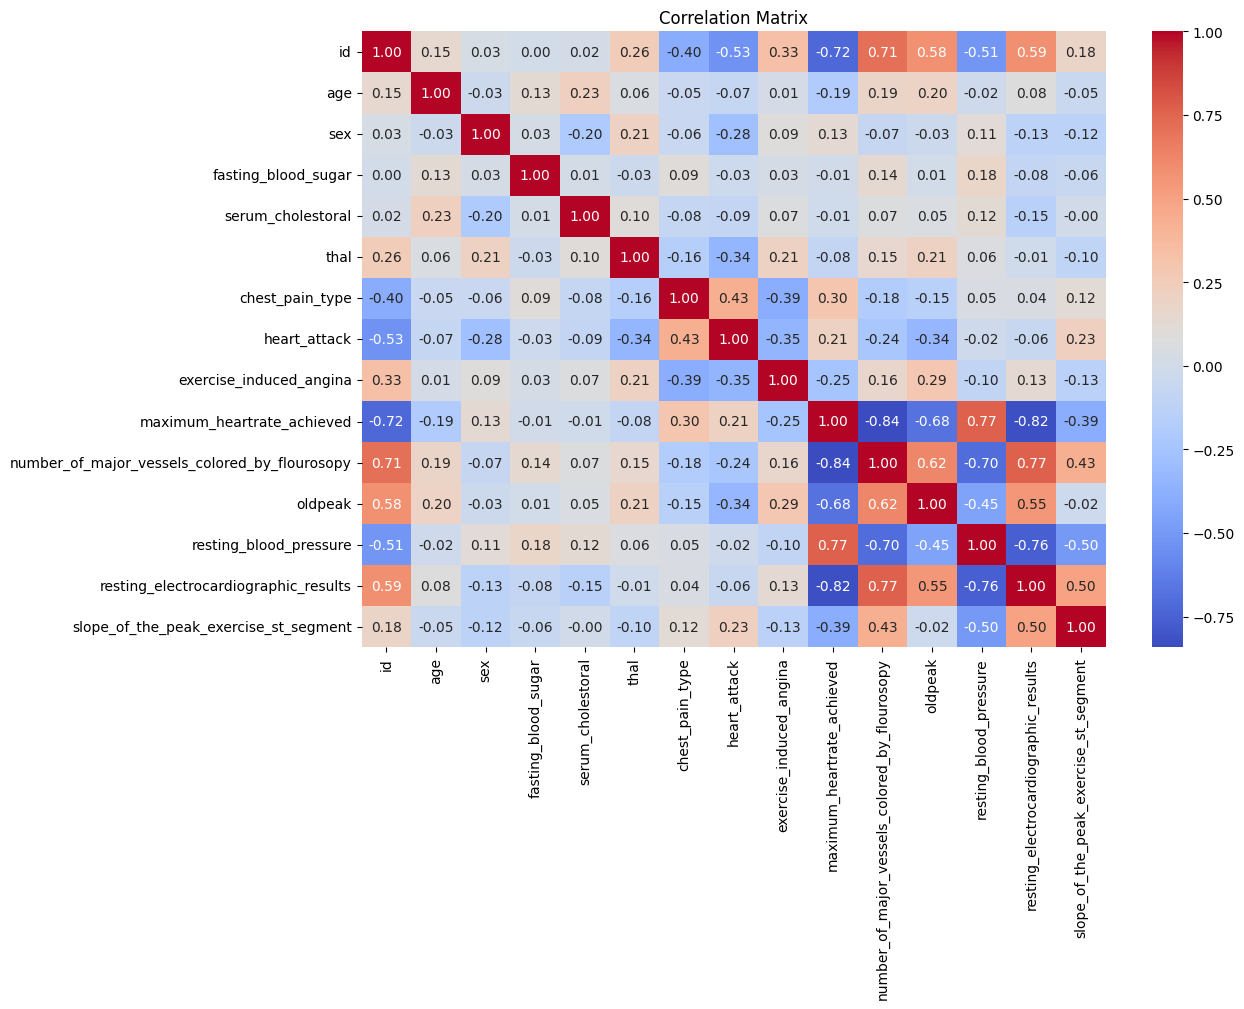

In [23]:
# correlations for all the columns in df except real_data
corr = df.drop('real_data', axis=1).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [24]:
df.real_data.unique()

array(['real data', None,
       'Evgeny likes white wine for lunch and red wine for dinner'],
      dtype=object)

In [ ]:
# make the col real_data only have 'real data' and None values
# we dont want the weird evgeny entry

df.real_data = df.real_data.apply(lambda x: 'real data' if x == 'real data' else None)
df.real_data.value_counts() 


real_data
real data    243
Name: count, dtype: int64

In [38]:
df[df.real_data.isnull()]

,id,age,sex,fasting_blood_sugar,serum_cholestoral,thal,chest_pain_type,heart_attack,exercise_induced_angina,maximum_heartrate_achieved,number_of_major_vessels_colored_by_flourosopy,oldpeak,real_data,resting_blood_pressure,resting_electrocardiographic_results,slope_of_the_peak_exercise_st_segment
4,4,57.0,0.0,0.0,354.0,2.0,0.0,1,1.0,163.0,0.0,0.6,None,120.0,1.0,2.0
9,9,57.0,1.0,0.0,168.0,2.0,2.0,1,0.0,174.0,0.0,1.6,None,150.0,1.0,2.0
14,14,58.0,0.0,1.0,283.0,2.0,3.0,1,0.0,162.0,0.0,1.0,None,150.0,0.0,2.0
19,19,69.0,0.0,0.0,239.0,2.0,3.0,1,0.0,151.0,2.0,1.8,None,140.0,1.0,2.0
24,24,40.0,1.0,0.0,199.0,3.0,3.0,1,1.0,178.0,0.0,1.4,None,140.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,398,75.0,1.0,NaN,NaN,NaN,NaN,0,0.0,0.0,5.0,3.0,None,86.0,74.0,3.0
399,399,90.0,1.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
400,400,68.0,1.0,NaN,NaN,NaN,NaN,0,1.0,1.0,6.0,4.0,None,11.0,90.0,2.0
401,401,20.0,1.0,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [39]:
df = df.dropna(subset=['real_data'])

In [41]:
df.isnull().sum()

id                                                0
age                                               7
sex                                              16
fasting_blood_sugar                               0
serum_cholestoral                                 0
thal                                              0
chest_pain_type                                   0
heart_attack                                      0
exercise_induced_angina                           0
maximum_heartrate_achieved                        9
number_of_major_vessels_colored_by_flourosopy     0
oldpeak                                           0
real_data                                         0
resting_blood_pressure                            0
resting_electrocardiographic_results              0
slope_of_the_peak_exercise_st_segment             0
dtype: int64

### What to do before FE

1. drop columns which are irrelevant: id, real_data
2. rename columns: shorten the columns
3. Baseline model: check correlations and maybe counts

### Feature Engineering

0. Set the numerical, categorical and ordinal columns and __scale numeric columns, one-hot categorical columns, encode ordinal columns__ 
1. Imputer: age, sex & maximum heartrate



In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('heart_attack', axis=1), 
    df['heart_attack'], 
    test_size=0.2, 
    random_state=RSEED, 
    stratify=df['heart_attack']
)

In [70]:
X_train.columns

Index(['id', 'age', 'sex', 'fasting_blood_sugar', 'serum_cholestoral', 'thal',
       'chest_pain_type', 'exercise_induced_angina',
       'maximum_heartrate_achieved',
       'number_of_major_vessels_colored_by_flourosopy', 'oldpeak', 'real_data',
       'resting_blood_pressure', 'resting_electrocardiographic_results',
       'slope_of_the_peak_exercise_st_segment'],
      dtype='object')

## Baseline Model

In [ ]:
# chest_pain_type, exercise_induced_angina, oldpeak seem to have good correlations with heart attack, so lets use it as features for
# a baseline model: logistic regression
X_baseline = df[['chest_pain_type', 'exercise_induced_angina', 'oldpeak']]
y_baseline = df['heart_attack']

X_train_bl, X_test_bl, y_train_bl, y_test_bl = train_test_split(
    X_baseline, 
    y_baseline, 
    test_size=0.2, 
    random_state=RSEED, 
    stratify=y_baseline
)
# train the model
baseline_mod = LogisticRegression(random_state=RSEED)
baseline_mod.fit(X_train_bl, y_train_bl)
y_pred_bl = baseline_mod.predict(X_test_bl)
y_test_predict_bl = baseline_mod.predict(X_test_bl)



#test the model
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)
score_bl = cross_val_score(baseline_mod, X_train_bl, y_train_bl, cv=cv, scoring='recall')
print("Baseline model cross-validation recall scores:", np.mean(score_bl))

Baseline model cross-validation recall scores: 0.8285714285714285


In [68]:
# define lists with columns for numerical and categorical features
numerical_features = ['serum_cholestoral',
                      'oldpeak', 'resting_blood_pressure', 'number_of_major_vessels_colored_by_flourosopy']
categorical_features = ['chest_pain_type', 'fasting_blood_sugar', 'thal', 'resting_electrocardiographic_results',
                         'exercise_induced_angina', 'slope_of_the_peak_exercise_st_segment']

In [92]:
numerical_pipeline = Pipeline(steps=[('scaler', StandardScaler())])
categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])
age_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

sex_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

mhr_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

transformer_5 = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
    ('age_impute', age_pipeline, ['age']),
    ('sex_impute', sex_pipeline, ['sex']),
    ('mhr_impute', mhr_pipeline, ['maximum_heartrate_achieved'])
]) 


model1_steps = [
    ('preprocessor', transformer_5),
    ('log_model', LogisticRegression(random_state=RSEED))
]

log_model =Pipeline(steps=model1_steps)



X_train_fe_1 = transformer_5.fit_transform(X_train, y_train)    
X_train_fe_1 = pd.DataFrame(X_train_fe_1, columns=transformer_5.get_feature_names_out())


log_model.fit(X_train, y_train)
y_pred_1 = log_model.predict(X_test)

### Model evaluation:
I use recall here since it penalizes false negatives, which could be crucial when detecting heart attacks

In [89]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RSEED)

scores = cross_val_score(log_model, X_train, y_train, cv=cv, scoring='recall')
print("Cross-validation scores:", np.mean(scores))



Cross-validation scores: 0.8761904761904763


/Users/kevin/Documents/week5_new/hands-on-ml/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### GridSearchCV


In [93]:
log_model.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['serum_cholestoral', 'oldpeak',
                                     'resting_blood_pressure',
                                     'number_of_major_vessels_colored_by_flourosopy']),
                                   ('cat',
                                    Pipeline(steps=[('ohe',
                                                     OneHotEncoder(drop='first',
                                                                   handle_unknown='ignore'))]),
                                    ['chest_pain_type', 'fasting_blood_sugar',
                                     'thal',
                                     'resting_electrocardiograp...
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('s

In [99]:
# Defining parameter grid (as dictionary)
param_grid = {'log_model__C' : [0.01, 0.1, 1, 10, 100],
              'log_model__penalty' : ['l1', 'l2', 'elasticnet', 'deprecated'],
              'log_model__class_weight' : [None, 'balanced'],
              'log_model__max_iter' : [100, 200, 300, 1000]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(log_model, param_grid, scoring='recall',
                  cv=5, verbose=1, n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs.fit(X_train, y_train)


Fitting 5 folds for each of 160 candidates, totalling 800 fits


/Users/kevin/Documents/week5_new/hands-on-ml/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/kevin/Documents/week5_new/hands-on-ml/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/kevin/Documents/week5_new/hands-on-ml/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarnin

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'log_model__C': [0.01, 0.1, ...], 'log_model__class_weight': [None, 'balanced'], 'log_model__max_iter': [100, 200, ...], 'log_model__penalty': ['l1', 'l2', ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the c

In [102]:
print(gs.best_params_)
print(gs.best_score_)
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)

#test the model with metrics and without kfold

print("Test recall:", recall_score(y_test, y_pred))
print("Test precision:", precision_score(y_test, y_pred))
print("Test f1:", f1_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


{'log_model__C': 0.01, 'log_model__class_weight': None, 'log_model__max_iter': 100, 'log_model__penalty': 'l2'}
0.9142857142857143
Test recall: 0.9259259259259259
Test precision: 0.8064516129032258
Test f1: 0.8620689655172413
Confusion matrix:
 [[16  6]
 [ 2 25]]
